In [1]:
# Import local modules
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from preprocessing import VandalismEncoder, RevisionGrouper, FeatureSelector
from persistence import save_model
from baseline import BASELINE_FEATURE_COLUMNS
from plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from ipywidgets import interactive

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Import dataset
df = pd.read_csv('./data/features-total-4a115a8.csv', index_col='revision_id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,sizeRatio,LZWCompressionRate,KLDOfCharDistribution,commentLength,userCommentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.000000,0.000000,0.0,...,11910.000000,0.513889,1024.000000,34.0,34.0,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,0.833333,0.857143,0.5,...,0.003832,0.308994,4.126739,14.0,14.0,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.000000,0.000000,0.0,...,0.003622,0.434896,85.525822,67.0,0.0,0.0,0.0,2.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.000000,0.000000,0.0,...,-0.000196,0.353894,1.286642,152.0,0.0,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,-1.000000,-1.000000,-1.0,...,0.000048,0.428264,342.595182,10.0,10.0,0.0,0.0,0.0,0.0,12


---
## Preprocessing

In [4]:
def preprocessing(frame, features='all', tag=1):
    feature_columns = None
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS

    preprocess_pipeline = Pipeline([
        ('vandalism_encoder', VandalismEncoder([tag])),
        ('revision_grouper', RevisionGrouper()),
        ('feature_selector', FeatureSelector(feature_columns))
    ])

    print('Feature config:', features, 'Selected tag:', tag)
    return preprocess_pipeline.transform(frame)

---
## Generate single label classifier per tag

Feature config: all Selected tag: 1
X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)
Best params {'class_weight': {0: 8, 1: 1}, 'n_estimators': 500}
Best score 0.6690613741705328


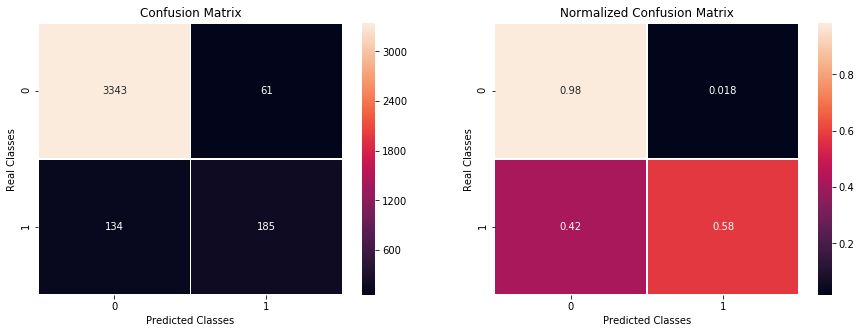

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.96      0.98      0.97      3404
   Vandalism       0.75      0.58      0.65       319

 avg / total       0.94      0.95      0.94      3723

Feature config: all Selected tag: 2
X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)
Best params {'class_weight': {0: 8, 1: 1}, 'n_estimators': 250}
Best score 0.41303060814591264


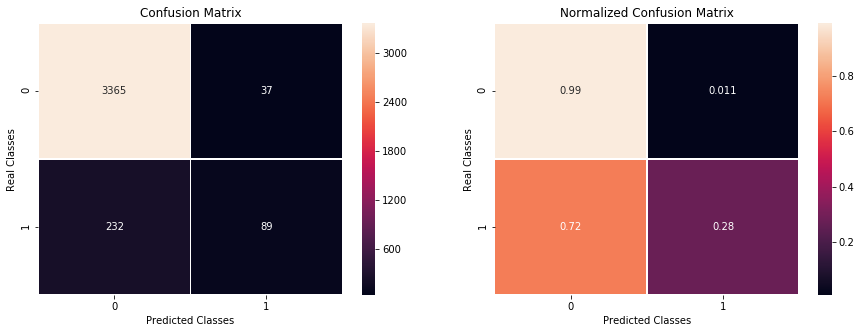

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.94      0.99      0.96      3402
   Vandalism       0.71      0.28      0.40       321

 avg / total       0.92      0.93      0.91      3723

Feature config: all Selected tag: 3
X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

Best params {'class_weight': 'balanced', 'n_estimators': 100}
Best score 0.010517833665549854


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

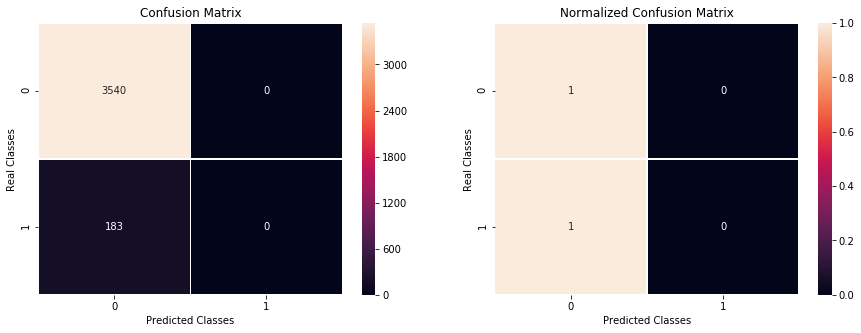

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.95      1.00      0.97      3540
   Vandalism       0.00      0.00      0.00       183

 avg / total       0.90      0.95      0.93      3723

Feature config: all Selected tag: 5


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

Best params {'class_weight': {0: 1, 1: 16}, 'n_estimators': 500}
Best score 0.17854719222316887


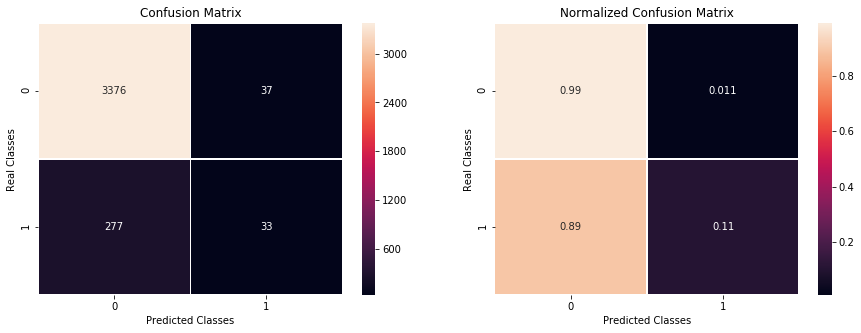

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.92      0.99      0.96      3413
   Vandalism       0.47      0.11      0.17       310

 avg / total       0.89      0.92      0.89      3723

Feature config: all Selected tag: 6
X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

Best params {'class_weight': {0: 4, 1: 1}, 'n_estimators': 500}
Best score 0.04007520816545796


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

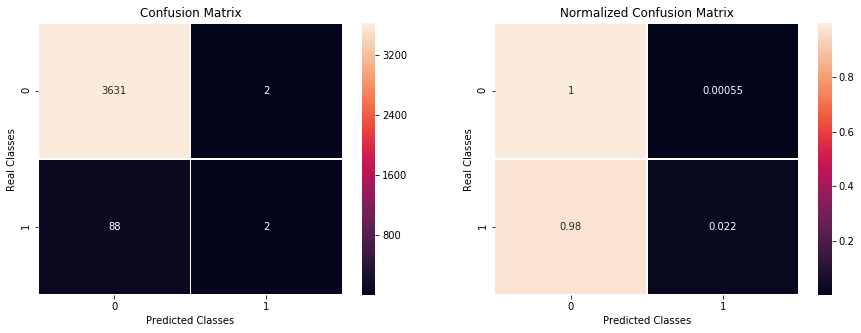

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.98      1.00      0.99      3633
   Vandalism       0.50      0.02      0.04        90

 avg / total       0.96      0.98      0.96      3723

Feature config: all Selected tag: 9
X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.p

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:

Best params {'class_weight': None, 'n_estimators': 100}
Best score 0.0


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:11

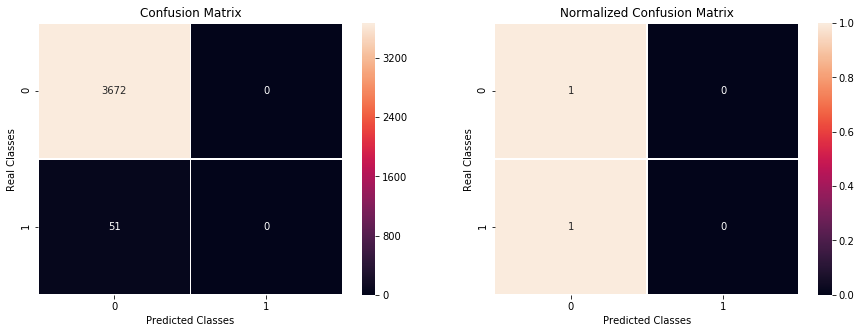

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.99      1.00      0.99      3672
   Vandalism       0.00      0.00      0.00        51

 avg / total       0.97      0.99      0.98      3723

Feature config: all Selected tag: 11


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


X train (3723, 83)
y train (3723,)
X test (1242, 83)
y test (1242,)
Best params {'class_weight': {0: 2, 1: 1}, 'n_estimators': 500}
Best score 0.495600224790605


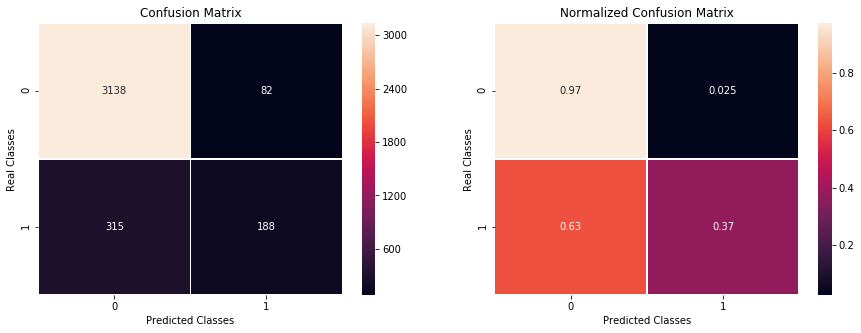

Classification Report
              precision    recall  f1-score   support

No Vandalism       0.91      0.97      0.94      3220
   Vandalism       0.70      0.37      0.49       503

 avg / total       0.88      0.89      0.88      3723



In [5]:
for tag in [1, 2, 3, 5, 6, 9, 11]:
    processed_df = preprocessing(df, 'all', tag)
    # X, y split
    X = processed_df.drop(['is_vandalism'], axis=1)
    y = processed_df['is_vandalism']
    
    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    print('X train', X_train.shape)
    print('y train', y_train.shape)
    print('X test', X_test.shape)
    print('y test', y_test.shape)
    
    # Grid search model params
    parameters = [{
        'n_estimators': [100, 250, 500, 750],
        'class_weight': [None, 'balanced', {0:1,1:1}, {0:1,1:2}, {0:1,1:4}, {0:1,1:8}, {0:1,1:16}, {0:2,1:1},  {0:4,1:1}, {0:8,1:1}, {0:16,1:1}]
    }]

    grid_search = GridSearchCV(RandomForestClassifier(),
                               parameters, 
                               scoring=['f1', 'precision', 'recall', 'roc_auc'],
                               refit='f1',
                               cv=10,
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)

    params = grid_search.best_params_
    print('Best params', grid_search.best_params_)
    print('Best score', grid_search.best_score_)
    
    # Train scores & predictions
    clf = RandomForestClassifier(n_estimators=params['n_estimators'], 
                                 class_weight=params['class_weight'], 
                                 n_jobs=-1)
    
    train_scores = cross_validate(clf, X_train, y_train,
                            scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                            cv=10, n_jobs=-1, return_train_score=False)

    y_train_predict = cross_val_predict(clf, X_train, y_train, cv=10, n_jobs=-1, method='predict')
    plot_confusion_matrix(y_train, y_train_predict)
    
    save_model(tag, clf, train_scores, grid_search)